<a href="https://colab.research.google.com/github/MKolaksazov/Data-Science/blob/main/Colab%20code%20(graphs)/Tukey_test_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drawing a 'BOXPLOT' graph

Includes letters, showing the significant differences between variants, derived by the means of the Tukey's test.

####1) importing of the libraries and the **.csv** file

The columns of this table file should containt parameters, whereas the group variants written as indexes of the rows. These indexes will be shown in the first column, named *'groups'*.

the delimiter is usually a semicolon ```;```, but can be a tabulation ```\t```


In [184]:
# PARAMETERS

file = 'CCI-2-stat.csv'
y_height = 88 # height of the graph
y_dist = 20 # distance between labels
parameter = 'cci_c' # required column

x_label = 'Sorghum cultivars'
'''
title_main = 'CO$_2$ uptake (A$_{n}$)'
y_label = r'$\mu$mol m$^{-2}$s$^{-1}$ CO$_2$'

'''
title_main = 'Concentration of chlorophyll'
y_label = 'cci'
# $\mu$g m$^{-2}$ chl (cci)

# PI $_{ABS}$ (performance index)
# (a.u.)

# TAC - water extracts
# mM AAE g${^-1}$

In [185]:
import pandas as pd
import numpy as np
# exp_0726_OJIP_p
df = pd.read_csv("/content/CCI-2-stat.csv", delimiter='\t', decimal=',') # delimiter '\t' or ';'

1.2) Popping out the labels of the variation groups in a dataframe, called *'names'*.
Transposing the dataframe, so that it can be easily processed by the covariance test analysis and matplotlib. Converting it into numpy array.

In [186]:
names = df.pop('groups')
transposed_df = df.T
named = np.array(names)
transposed_df

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
Unnamed: 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cci_c,51.7,58.0,72.0,61.9,47.1,61.7,59.0,49.2,64.4,50.0,...,57.5,54.7,60.9,51.9,28.8,63.1,18.2,40.2,54.0,35.4


1.3) An optional step required to abbreviate the longer latin names of the crops, so that they can fit in the graph.

In [187]:
import re
# Abbreviating the latin names from 'Aaaaa aaaaaa (L.)' to 'A. aaaaaa (L.)'
for i in range(len(names)):
    c = names[i][0]
    names[i] = re.sub(r'[A-Z]([a-z]+ )', c + '. ', names[i])
names

0      MB
1      MB
2      MB
3      MB
4      MB
5      MB
6      MB
7      MB
8      MB
9      MB
10     B1
11     B1
12     B1
13     B1
14     B1
15     B1
16     B1
17     B1
18     B1
19     B1
20     B2
21     B2
22     B2
23     B2
24     B2
25     B2
26     B2
27     B2
28     B2
29     B3
30     B3
31     B3
32     B3
33     B3
34     B3
35     B3
36     B3
37     B3
38    Ch2
39    Ch2
40    Ch2
41    Ch2
42    Ch2
43    Ch2
44    Ch2
45    Ch2
46    Ch1
47    Ch1
48    Ch1
49    Ch1
50    Ch1
51    Ch1
52    Ch1
53     MR
54     MR
55     MR
56     MR
57     MR
58     MR
Name: groups, dtype: object

1.4) Popping out the column with the desired parameter by writing the name in the 'pop' function, as well as transposing it.

In [188]:
params = df.pop(parameter) #required param
transp_df = params.T

#dff = np.array(params)

1.5) Converting the dataframe into a 1D numpy array

In [189]:
from matplotlib.patches import namedtuple
#convert dataframe to matrix
conv_arr= transp_df.values

#split matrix into 3 columns each into 1d array

#converting into 1D array
one_D_array = conv_arr.ravel()

print(one_D_array)

# variants as well:
print(names)

[51.7 58.  72.  61.9 47.1 61.7 59.  49.2 64.4 50.  40.  47.1 35.6 38.2
 28.3 43.7 45.3 59.8 33.3 58.1 77.6 64.4 64.1 72.6 75.6 71.6 70.2 53.1
 69.4 47.  46.8 47.9 60.3 64.1 48.6 65.5 62.  48.6 60.7 58.1 68.1 52.4
 57.5 61.6 64.8 57.8 61.2 67.  53.7 57.5 54.7 60.9 51.9 28.8 63.1 18.2
 40.2 54.  35.4]
0      MB
1      MB
2      MB
3      MB
4      MB
5      MB
6      MB
7      MB
8      MB
9      MB
10     B1
11     B1
12     B1
13     B1
14     B1
15     B1
16     B1
17     B1
18     B1
19     B1
20     B2
21     B2
22     B2
23     B2
24     B2
25     B2
26     B2
27     B2
28     B2
29     B3
30     B3
31     B3
32     B3
33     B3
34     B3
35     B3
36     B3
37     B3
38    Ch2
39    Ch2
40    Ch2
41    Ch2
42    Ch2
43    Ch2
44    Ch2
45    Ch2
46    Ch1
47    Ch1
48    Ch1
49    Ch1
50    Ch1
51    Ch1
52    Ch1
53     MR
54     MR
55     MR
56     MR
57     MR
58     MR
Name: groups, dtype: object


####2) arranging the data by samples column-wise and taking out the names of the variants in a different array

Converting the 2-D pandas dataframe into a 1-D numpy array. ```numpy.append(array1, array2) ``` can be used to append two arrays.

Probably ```pandas.dataframe.pop()``` can be used as well.

In [190]:
# Sample data (replace this with your data)
data = pd.DataFrame({
    'Variant': names,
    'Value': one_D_array
})

3) performing the co-variance test
(the following is a variant, showing the t-test)
(currently not shown)

4) This is a very simple code, showing a Tukey's test analysis and printing the summarized data

In [191]:
import statsmodels.stats.multicomp as mc

# Perform one-way ANOVA to check for significant differences
model = mc.MultiComparison(data['Value'], data['Variant'])
result = model.tukeyhsd()

print(result.summary(), len(result.reject))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    B1     B2  25.7933    0.0  13.2151  38.3716   True
    B1     B3  11.5933 0.0893  -0.9849  24.1716  False
    B1    Ch1  15.1886  0.018   1.6977  28.6794   True
    B1    Ch2   17.185  0.003   4.1996  30.1704   True
    B1     MB    14.56 0.0103   2.3172  26.8028   True
    B1     MR    -2.99 0.9947 -17.1267  11.1467  False
    B2     B3    -14.2 0.0223  -27.105   -1.295   True
    B2    Ch1 -10.6048 0.2376 -24.4008   3.1913  False
    B2    Ch2  -8.6083 0.4365 -21.9105   4.6938  False
    B2     MB -11.2333 0.1089 -23.8116   1.3449  False
    B2     MR -28.7833    0.0 -43.2116 -14.3551   True
    B3    Ch1   3.5952  0.984 -10.2008  17.3913  False
    B3    Ch2   5.5917 0.8538  -7.7105  18.8938  False
    B3     MB   2.9667 0.9905  -9.6116  15.5449  False
    B3     MR -14.5833  0.046 -29.0116  -0.1551   True
   Ch1    

In [192]:
import scipy.stats as stats
import matplotlib.pyplot as plt

y_ticks = range(0, y_height, y_dist)

In [193]:
# define columns for data and then grouping
col_to_group='Variant'
col_for_data='Value'

#Now take teh data and regroup for anova
samples = [cols[1] for cols in data.groupby('Variant')['Value']]
#I am not sure how this works but it makes an numpy array for each group
f_val, p_val = stats.f_oneway(*samples)
# I am not sure what this star does but this passes all the numpy arrays correctly

# this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
#if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
mod = mc.MultiComparison(data['Value'], data['Variant'])
thsd=mod.tukeyhsd()

#this is a function to do Piepho method.
#AN Alogrithm for a letter based representation of al-pairwise comparisons.
tot=len(thsd.groupsunique)
#make an empty dataframe that is a square matrix of size of the groups. #set first column to 1
df_ltr=pd.DataFrame(np.nan, index=np.arange(tot),columns=np.arange(tot))
#df_ltr.iloc[:,0]=1
df_ltr[df_ltr.columns[0]] = 1
#df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)

count=0
df_nms = pd.DataFrame('', index=np.arange(tot), columns=['names'])
# I make a dummy dataframe to put axis labels into.  sd stands for signifcant difference

for i in np.arange(tot):   #I loop through and make all pairwise comparisons.
    for j in np.arange(i+1,tot):
        #print('i=',i,'j=',j,thsd.reject[count])
        if thsd.reject[count]==True:
            for cn in np.arange(tot):
                if df_ltr.iloc[i,cn]==1 and df_ltr.iloc[j,cn]==1:
                  #If the column contains both i and j shift and duplicat
                    df_ltr=pd.concat([df_ltr.iloc[:,:cn+1],df_ltr.iloc[:,cn+1:].T.shift().T],axis=1)
                    df_ltr[df_ltr.columns[cn+1]]=df_ltr[df_ltr.columns[cn]]
                    df_ltr.iloc[i,cn]=0
                    df_ltr.iloc[j,cn+1]=0
                #Now we need to check all columns for abosortpion.
                for cleft in np.arange(len(df_ltr.columns)-1):
                    for cright in np.arange(cleft+1,len(df_ltr.columns)):
                        if (df_ltr[df_ltr.columns[cleft]].isna()).all()==False and (df_ltr[df_ltr.columns[cright]].isna()).all()==False:
                            if (df_ltr[df_ltr.columns[cleft]]>=df_ltr[df_ltr.columns[cright]]).all()==True:
                                df_ltr[df_ltr.columns[cright]]=0
                                df_ltr=pd.concat([df_ltr[df_ltr.columns[:cright]],df_ltr[df_ltr.columns[cright:]].T.shift(-1).T],axis=1)
                            if (df_ltr[df_ltr.columns[cleft]]<=df_ltr[df_ltr.columns[cright]]).all()==True:
                                df_ltr[df_ltr.columns[cleft]]=0
                                df_ltr=pd.concat([df_ltr[df_ltr.columns[:cleft]],df_ltr[df_ltr.columns[cleft:]].T.shift(-1).T],axis=1)

        count+=1

#I sort so that the first column becomes A
df_ltr=df_ltr.sort_values(by=list(df_ltr.columns),axis=1,ascending=False)

# I assign letters to each column
for cn in np.arange(len(df_ltr.columns)):
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(1,chr(97+cn))
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(0,'')
    df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(np.nan,'')

#I put all the letters into one string
df_ltr=df_ltr.astype(str)
df_ltr.sum(axis=1)


0    ab
1     c
2    ad
3    cd
4    cd
5    cd
6     b
dtype: object

In [194]:
def draw_letters(y, follow_bars):

  for i,grp in enumerate(grps):   #I loop through the groups to make the scatters and figure out the axis labels.
      if follow_bars:
        plt = 1
        y_pos = data[data['Variant'] == grp]['Value'].max() + y * 0.05
      else:
        plt = 0
        y_pos = y - y * 0.05 #y_pos = ax.get_ylim()[1]*1
      ax.text(i+plt,y_pos,df_ltr.sum(axis=1)[i],
              rotation=0,fontsize=10,verticalalignment='top',horizontalalignment='center')


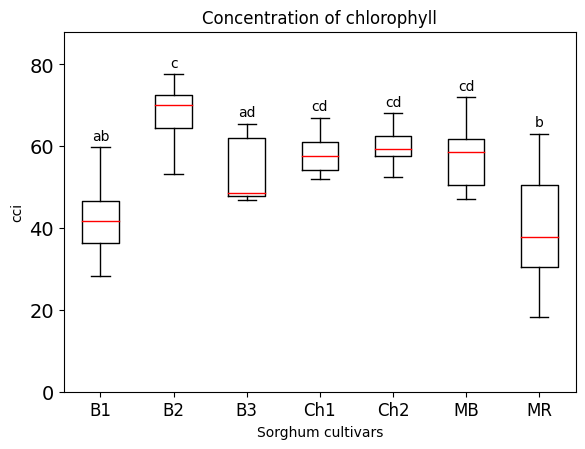

In [199]:

#Now to plot like R with a violing plot
fig,ax=plt.subplots()
data.boxplot(column=col_for_data, by=col_to_group,ax=ax,fontsize=14,
             medianprops=dict(color='red'),
             boxprops=dict(color='black'),
             whiskerprops=dict(color='black')
             )
#, #patch_artist=True)

#,showmeans=True
#,boxprops=dict(linewidth=2.0),whiskerprops=dict(linewidth=2.0))  #This makes the boxplot

grps=pd.unique(data[col_to_group].values)   #Finds the group names
grps.sort() # This is critical!  Puts the groups in alphabeical order to make it match the plotting

#props=dict(facecolor='white',alpha=1)

draw_letters(y_height, True)

plt.ylim(ymax=y_height)
ax.set_yticks(y_ticks)

ax.set_xticklabels(grps,rotation=0,fontsize=12)

ax.set(title=title_main, ylabel=y_label, xlabel=x_label)
fig.suptitle('')

plt.grid(False)
#fig.savefig('anovatest.jpg',dpi=600,bbox_inches='tight')

In [196]:
stat_result = data.groupby(['Variant'], as_index=False).agg(
                      {'Value':['mean','std']})
stat_result['Value']['std']

0    10.164120
1     7.383935
2     8.152914
3     5.265838
4     4.840823
5     7.918333
6    16.440651
Name: std, dtype: float64

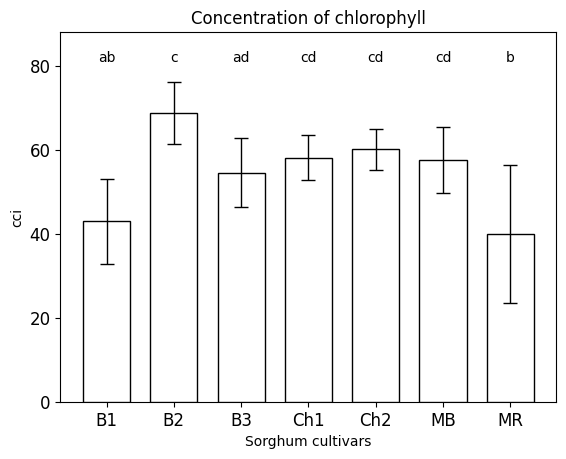

In [197]:
menMeans = stat_result['Value']['mean']
menStd = stat_result['Value']['std']
labels = stat_result['Variant']

ind  = np.arange(7)    # the x locations for the groups
width= 0.7
# Pull the formatting out here
bar_kwargs = {'width':width,'color':'white','linewidth':1,'zorder':5,'edgecolor':'black'}
err_kwargs = {'linewidth':1,'ecolor':'black','capsize':5, 'capthick':1}
#'zorder':0, - only up err bars
#for matplotlib >= v1.4 use 'fmt':'none' instead

fig, ax = plt.subplots()

ax.p1 = plt.bar(ind, menMeans, yerr=menStd, error_kw=err_kwargs, **bar_kwargs)
#ax.errs = plt.errorbar(ind, menMeans, yerr=menStd, **err_kwargs)

draw_letters(y_height, False)

ax.set(title=title_main, ylabel=y_label, xlabel=x_label)

plt.xticks(ind, labels, color='k')
ax.set_xticklabels(grps, rotation=0, fontsize=12)

plt.ylim(ymax=y_height)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=12)

fig.suptitle('')
plt.show()

In [198]:
# Custom function to draw the diff bars
'''
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i],y+7), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# Call the function
label_diff(0,1,'p=0.0370',ind,menMeans)
label_diff(1,2,'p<0.0001',ind,menMeans)
label_diff(2,3,'p=0.0025',ind,menMeans)
'''

"\ndef label_diff(i,j,text,X,Y):\n    x = (X[i]+X[j])/2\n    y = 1.1*max(Y[i], Y[j])\n    dx = abs(X[i]-X[j])\n\n    props = {'connectionstyle':'bar','arrowstyle':'-',                 'shrinkA':20,'shrinkB':20,'linewidth':2}\n    ax.annotate(text, xy=(X[i],y+7), zorder=10)\n    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)\n\n# Call the function\nlabel_diff(0,1,'p=0.0370',ind,menMeans)\nlabel_diff(1,2,'p<0.0001',ind,menMeans)\nlabel_diff(2,3,'p=0.0025',ind,menMeans)\n"